# Aumento de datos
## Información de los datos

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils import np_utils
from sklearn.datasets import load_files   
import numpy as np
from collections import Counter
from tqdm import tqdm
import pickle

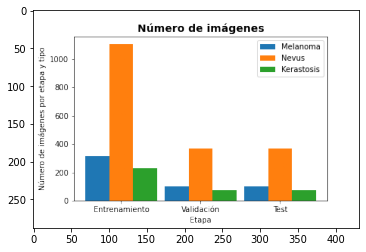

In [18]:
img = mpimg.imread('/Users/inma/Desktop/tfg/codigo/resultados/09-grafica_barras_nuevo_imagenes_etapa_tipo.png')
imgplot = plt.imshow(img)
plt.show()

Como vemos está descompensado, por lo que vamos a intentar arreglarlo.

## Oversampling

In [ ]:
data_train_path = "/Users/inma/Desktop/tfg/datos_equilibrados/train"
data_valid_path = "/Users/inma/Desktop/tfg/datos_equilibrados/valid"
data_test_path = "/Users/inma/Desktop/tfg/datos_equilibrados/test"

In [20]:
# define function to load train, test, and validation datasets
def load_data_raw (path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 3)
    
    return files, targets

train_filenames, train_targets = load_data_raw(data_train_path)
#val_filenames, val_targets = load_data_raw(data_valid_path)

Desarrollando el código, encontré un error y descubrí que se habían generado 3 paths no válidos, son estos:

In [21]:
# encontrar el path que da error
paths_erroneos_train = []
#paths_erroneos_val = []

for path in train_filenames:
    if 'DS_Store' in path:
        print(path)
        paths_erroneos_train.append(path)

#for path in val_filenames:
    #if 'DS_Store' in path:
        #print(path)
        #paths_erroneos_val.append(path)        

/Users/inma/Desktop/tfg/datos_equilibrados/train/melanoma/.DS_Store
/Users/inma/Desktop/tfg/datos_equilibrados/train/seborrheic_keratosis/.DS_Store
/Users/inma/Desktop/tfg/datos_equilibrados/train/nevus/.DS_Store


In [22]:
print(paths_erroneos_train)
#print(paths_erroneos_val)

['/Users/inma/Desktop/tfg/datos_equilibrados/train/melanoma/.DS_Store', '/Users/inma/Desktop/tfg/datos_equilibrados/train/seborrheic_keratosis/.DS_Store', '/Users/inma/Desktop/tfg/datos_equilibrados/train/nevus/.DS_Store']


No sé de donde salen esos ficheros, pero hay que eliminarlos.

In [23]:
np.where(train_filenames == paths_erroneos_train[0])

(array([1192]),)

In [24]:
np.where(train_filenames == paths_erroneos_train[1])

(array([1243]),)

In [25]:
np.where(train_filenames == paths_erroneos_train[2])

(array([1641]),)

#### Eliminar de train_filenames y de train_targets

Primero sacar una lista con los índices de los path erróneos:

In [26]:
error_train_id = []
#error_val_id = []

for i, path in enumerate(train_filenames):
    if path in paths_erroneos_train:
        error_train_id.append(i)
        
#for i, path in enumerate(val_filenames):
    #if path in paths_erroneos_val:
        #error_val_id.append(i)        

print(error_train_id)
#print(error_val_id)

[1192, 1243, 1641]


A continuación, eliminamos esos objetos de train_filenames y train_targets:

In [27]:
train_filenames = np.delete(train_filenames, error_train_id)
#val_filenames = np.delete(val_filenames, error_val_id)

In [28]:
print(len(train_filenames))
print(len(train_targets))

1652
1655


In [29]:
#print(len(val_filenames))
#print(len(val_targets))

In [30]:
train_targets = [target for i, target in enumerate(train_targets) if i not in error_train_id]
#val_targets = [target for i, target in enumerate(val_targets) if i not in error_val_id]

In [31]:
print(len(train_targets))
#print(len(val_targets))

1652


In [32]:
print(type(train_targets))
#print(type(val_targets))

<class 'list'>


In [33]:
train_targets = np.array(train_targets)
#val_targets = np.array(val_targets)

In [34]:
print(type(train_targets))
#print(type(val_targets))

<class 'numpy.ndarray'>


Solucionado esto, seguimos con el código:

<BarContainer object of 3 artists>

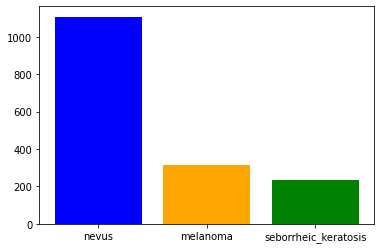

In [35]:
filenames_trimmed = [filename.split('/')[-2] for filename in train_filenames]
classes_count = Counter(filenames_trimmed)

# Plot the classes
plt.bar(classes_count.keys(), classes_count.values(), color=['blue', 'orange', 'green'])

In [36]:
def plot_n_samples(filenames):
    filenames_trimmed = [filename.split('/')[-2] for filename in filenames]
    classes_count = Counter(filenames_trimmed)

    # Plot the classes
    plt.bar(classes_count.keys(), classes_count.values(), color=['blue', 'orange', 'green'])

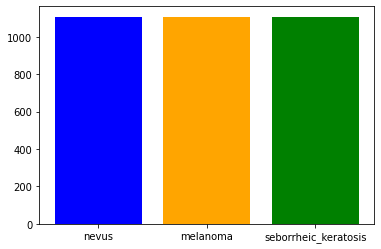

In [37]:
from sklearn.utils import resample, shuffle

# Choose one of the 3 for the feature_name
feature_names = {0: 'melanoma', 1: 'nevus', 2: 'seborrheic_keratosis'}

def upsample(filenames, targets, feature_name, n_samples = 1107):
    upsample_idx = []
    

    # Find all the indices for nevus
    for i, path in enumerate(filenames):
        # If feature matches, save the index
        if feature_name in path.split('/'):
            upsample_idx.append(i)
    
    # Remove selected features from filenames to add the upsampled after
    new_filenames = [filename for i, filename in enumerate(filenames) if i not in upsample_idx]
    new_targets = [target for i, target in enumerate(targets) if i not in upsample_idx]

    # Upsample
    resampled_x, resampled_y = resample(filenames[upsample_idx], targets[upsample_idx], n_samples=n_samples, random_state=0)

    # Add the upsampled features to new_filenames and new_targets
    new_filenames += list(resampled_x)
    new_targets += list(resampled_y) 
    
    return np.array(new_filenames), np.array(new_targets)
    
# We upsample twice: once for each feature we want upsampled
upsample_train_x, upsample_train_y = upsample(train_filenames, train_targets, feature_names[0])
upsample_train_x, upsample_train_y = upsample(upsample_train_x, upsample_train_y, feature_names[2])

#upsample_val_x, upsample_val_y = upsample(val_filenames, val_targets, feature_names[0], n_samples = 368)
#upsample_val_x, upsample_val_y = upsample(upsample_val_x, upsample_val_y, feature_names[2], n_samples = 368)

plot_n_samples(upsample_train_x)
#plot_n_samples(upsample_val_x)

In [38]:
feature_names

{0: 'melanoma', 1: 'nevus', 2: 'seborrheic_keratosis'}

In [39]:
len(upsample_train_x)

3321

El número es correcto: 1107 x 3 = 3321.

In [40]:
from keras.preprocessing import image   

# Convert the image paths to tensors Manually
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224,224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


train_filenames = paths_to_tensor(upsample_train_x)
train_targets = upsample_train_y

#val_filenames = paths_to_tensor(upsample_val_x)
#val_targets = upsample_val_y

100%|███████████████████████████████████████| 3321/3321 [07:14<00:00,  7.65it/s]


#### Guardar los datos 

In [41]:
pickle.dump(train_filenames, open('variablesGuardadas/oversampling/train_filenames.pkl', 'wb'))
pickle.dump(train_targets, open('variablesGuardadas/oversampling/train_targets.pkl', 'wb'))

#pickle.dump(val_filenames, open('variablesGuardadas/dataAugmentation/val_filenames.pkl', 'wb'))
#pickle.dump(val_targets, open('variablesGuardadas/dataAugmentation/val_targets.pkl', 'wb'))

#### Cargar los datos

In [3]:
train_filenames = pickle.load(open('variablesGuardadas/oversampling/train_filenames.pkl', 'rb'))
train_targets = pickle.load(open('variablesGuardadas/oversampling/train_targets.pkl', 'rb'))

#val_filenames = pickle.load(open('variablesGuardadas/dataAugmentation/val_filenames.pkl', 'rb'))
#val_targets = pickle.load(open('variablesGuardadas/dataAugmentation/val_targets.pkl', 'rb'))

In [4]:
train_targets

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [5]:
train_filenames

array([[[[188., 151., 143.],
         [186., 149., 141.],
         [190., 151., 144.],
         ...,
         [199., 173., 174.],
         [194., 164., 164.],
         [202., 168., 166.]],

        [[189., 151., 140.],
         [187., 149., 140.],
         [191., 152., 145.],
         ...,
         [201., 172., 174.],
         [190., 161., 163.],
         [198., 165., 160.]],

        [[188., 145., 136.],
         [190., 153., 145.],
         [191., 154., 145.],
         ...,
         [201., 177., 177.],
         [193., 168., 171.],
         [190., 160., 160.]],

        ...,

        [[194., 162., 163.],
         [201., 169., 170.],
         [190., 160., 158.],
         ...,
         [196., 165., 160.],
         [197., 166., 163.],
         [199., 168., 165.]],

        [[196., 159., 153.],
         [195., 156., 149.],
         [196., 166., 166.],
         ...,
         [196., 165., 162.],
         [196., 165., 162.],
         [194., 163., 158.]],

        [[195., 164., 162.],
       

### Generador de imágenes

In [42]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255) # rescale = reducir la dimension
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [44]:
train_data = train_gen.flow(train_filenames, train_targets, batch_size=64)
val_data = val_gen.flow_from_directory(data_valid_path,
                                           target_size = (224,224),
                                           class_mode = "categorical",
                                           batch_size = 64
                                          )

test_data = test_gen.flow_from_directory(data_test_path,
                                           target_size = (224,224),
                                           class_mode = "categorical",
                                           batch_size = 64
                                          )

Found 549 images belonging to 3 classes.
Found 549 images belonging to 3 classes.


Número de imágenes en cada etapa:

In [45]:
num_train = len(train_filenames)
num_valid = len(val_data.filenames)
num_test = len(test_data.filenames)

print(num_train, num_valid, num_test)

3321 549 549


#### Obtener el indice de cada clase

In [46]:
# Class name to the index
#class_2_indices = train_generator.class_indices
class_2_indices = {'melanoma': 0, 'nevus': 1, 'seborrheic_keratoses': 2}
print("Class to index:", class_2_indices)

# Reverse dict with the class index to the class name
indices_2_class = {v: k for k, v in class_2_indices.items()}
print("Index to class:", indices_2_class)

Class to index: {'melanoma': 0, 'nevus': 1, 'seborrheic_keratoses': 2}
Index to class: {0: 'melanoma', 1: 'nevus', 2: 'seborrheic_keratoses'}
